# Early Prediction of Sepsis from Clinical Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pickle

## Load Data


In [2]:
train_data = pd.read_csv(f'/Users/ofrihefetz/PycharmProjects/lab2_hw1/data/train_df.csv')
test_data = pd.read_csv('/Users/ofrihefetz/PycharmProjects/lab2_hw1/data/test_df.csv')

# Data Preperations
In this part we will prepare the different forms of the data set, which we will examine over different models.

In [3]:
def data_prep(data):
    #  add a new column for each feature that indicates if the value is missing
    for col in data.columns:
        data[col + '_missing'] = data[col].isna().astype(int)
    return data

##  Train data sets


In [4]:
col_to_drop_new = ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing',
                   'filename_missing', 'filename']
col_to_drop = ['SepsisPatient', 'SepsisLabel', 'filename']
# ------------------------------------------------------------------------------------#
# original data no manipulation
train_data_x = train_data.drop(col_to_drop, axis=1)
train_data_y = train_data['SepsisLabel']
# # ------------------------------------------------------------------------------------#
# original data with additional cols indicating for missing values per feature
train_data_new = data_prep(train_data)
train_data_new_x = train_data_new.drop(col_to_drop_new, axis=1)
train_data_new_y = train_data_new['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# original data aggregated by the patient id (using median values)
train_data_agg_x = train_data.groupby(by=['filename']).median()
train_data_agg_x = train_data_agg_x.drop(['SepsisPatient', 'SepsisLabel'], axis=1)
train_data_agg_y = train_data.groupby(by=['filename']).max()['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# # data with additional cols aggregated  by the patient id (using median values)
train_data_new_agg_x = train_data_new.groupby(by=['filename']).median()
train_data_new_agg_x = train_data_new_agg_x.drop(
    ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing', 'filename_missing'], axis=1)
train_data_new_agg_y = train_data_new.groupby(by=['filename']).max()['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using mean values)
train_data_added_agg_x = train_data_new.groupby(by=['filename']).mean()
train_data_added_agg_x = train_data_added_agg_x.drop(
    ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing', 'filename_missing'], axis=1)
# # ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using mean+median values)
train_combined_data = train_data_added_agg_x.drop(['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS'], axis=1)
train_combined_data = train_combined_data.add_prefix('mean')
train_combined_data_x = pd.concat([train_combined_data, train_data_new_agg_x], axis=1, join='inner')

## Test data sets

In [5]:
# original data no manipulation
test_data_x = test_data.drop(col_to_drop, axis=1)
test_data_y = test_data['SepsisLabel']
# # ------------------------------------------------------------------------------------#
# original data with additional cols indicating for missing values per feature
test_data_new = data_prep(test_data)
test_data_new_x = test_data_new.drop(col_to_drop_new, axis=1)
test_data_new_y = test_data_new['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# original data aggregated by the patient id (using median values)
test_data_agg_x = test_data.groupby(by=['filename']).median()
test_data_agg_x = test_data_agg_x.drop(['SepsisPatient', 'SepsisLabel'], axis=1)
test_data_agg_y = test_data.groupby(by=['filename']).max()['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using median values)
test_data_new_agg_x = test_data_new.groupby(by=['filename']).median()
test_data_new_agg_x = test_data_new_agg_x.drop(
    ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing', 'filename_missing'], axis=1)
test_data_new_agg_y = test_data_new.groupby(by=['filename']).max()['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using mean values)
test_data_added_agg_x = test_data_new.groupby(by=['filename']).mean()
test_data_added_agg_x = test_data_added_agg_x.drop(
    ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing', 'filename_missing'], axis=1)
# ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using mean+median values)
test_combined_data = test_data_added_agg_x.drop(['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS'], axis=1)
test_combined_data = test_combined_data.add_prefix('mean')
test_combined_data_x = pd.concat([test_combined_data, test_data_new_agg_x], axis=1, join='inner')

# Methods
1. Logistic_Regression
2. Gaussian_Naive_Bayes_Classifier
3. XGBoost
4. DecisionTree

In [6]:
def evaluation(y_test, predicted):
    accuracy_score(y_test, predicted)
    print(f"Accuracy is {accuracy_score(y_test, predicted)}")
    print(f"F1 score is {f1_score(y_test, predicted)}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predicted))

In [10]:
def get_dt_graph(dt_classifier):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt_classifier,
                       feature_names=train_data_x.columns,
                       class_names=['No Disease', "Disease"],
                       filled=True)

## DecisionTree

In [33]:
def DecisionTree(X_train, y_train, X_test, y_test):
    X_train = X_train.fillna(-1)
    X_test = X_test.fillna(-1)
    y_train = y_train.fillna(0)
    clf_entropy = DecisionTreeClassifier(criterion="entropy", random_state=100, max_depth=35, min_samples_leaf=50)
    clf_entropy.fit(X_train, y_train)
    y_pred_en = clf_entropy.predict(X_test)
    evaluation(y_test, y_pred_en)
   # gph = get_dt_graph(clf_entropy)

Accuracy is 0.9980476417567535
F1 score is 0.0
Confusion Matrix:
[[378800      0]
 [   741      0]]


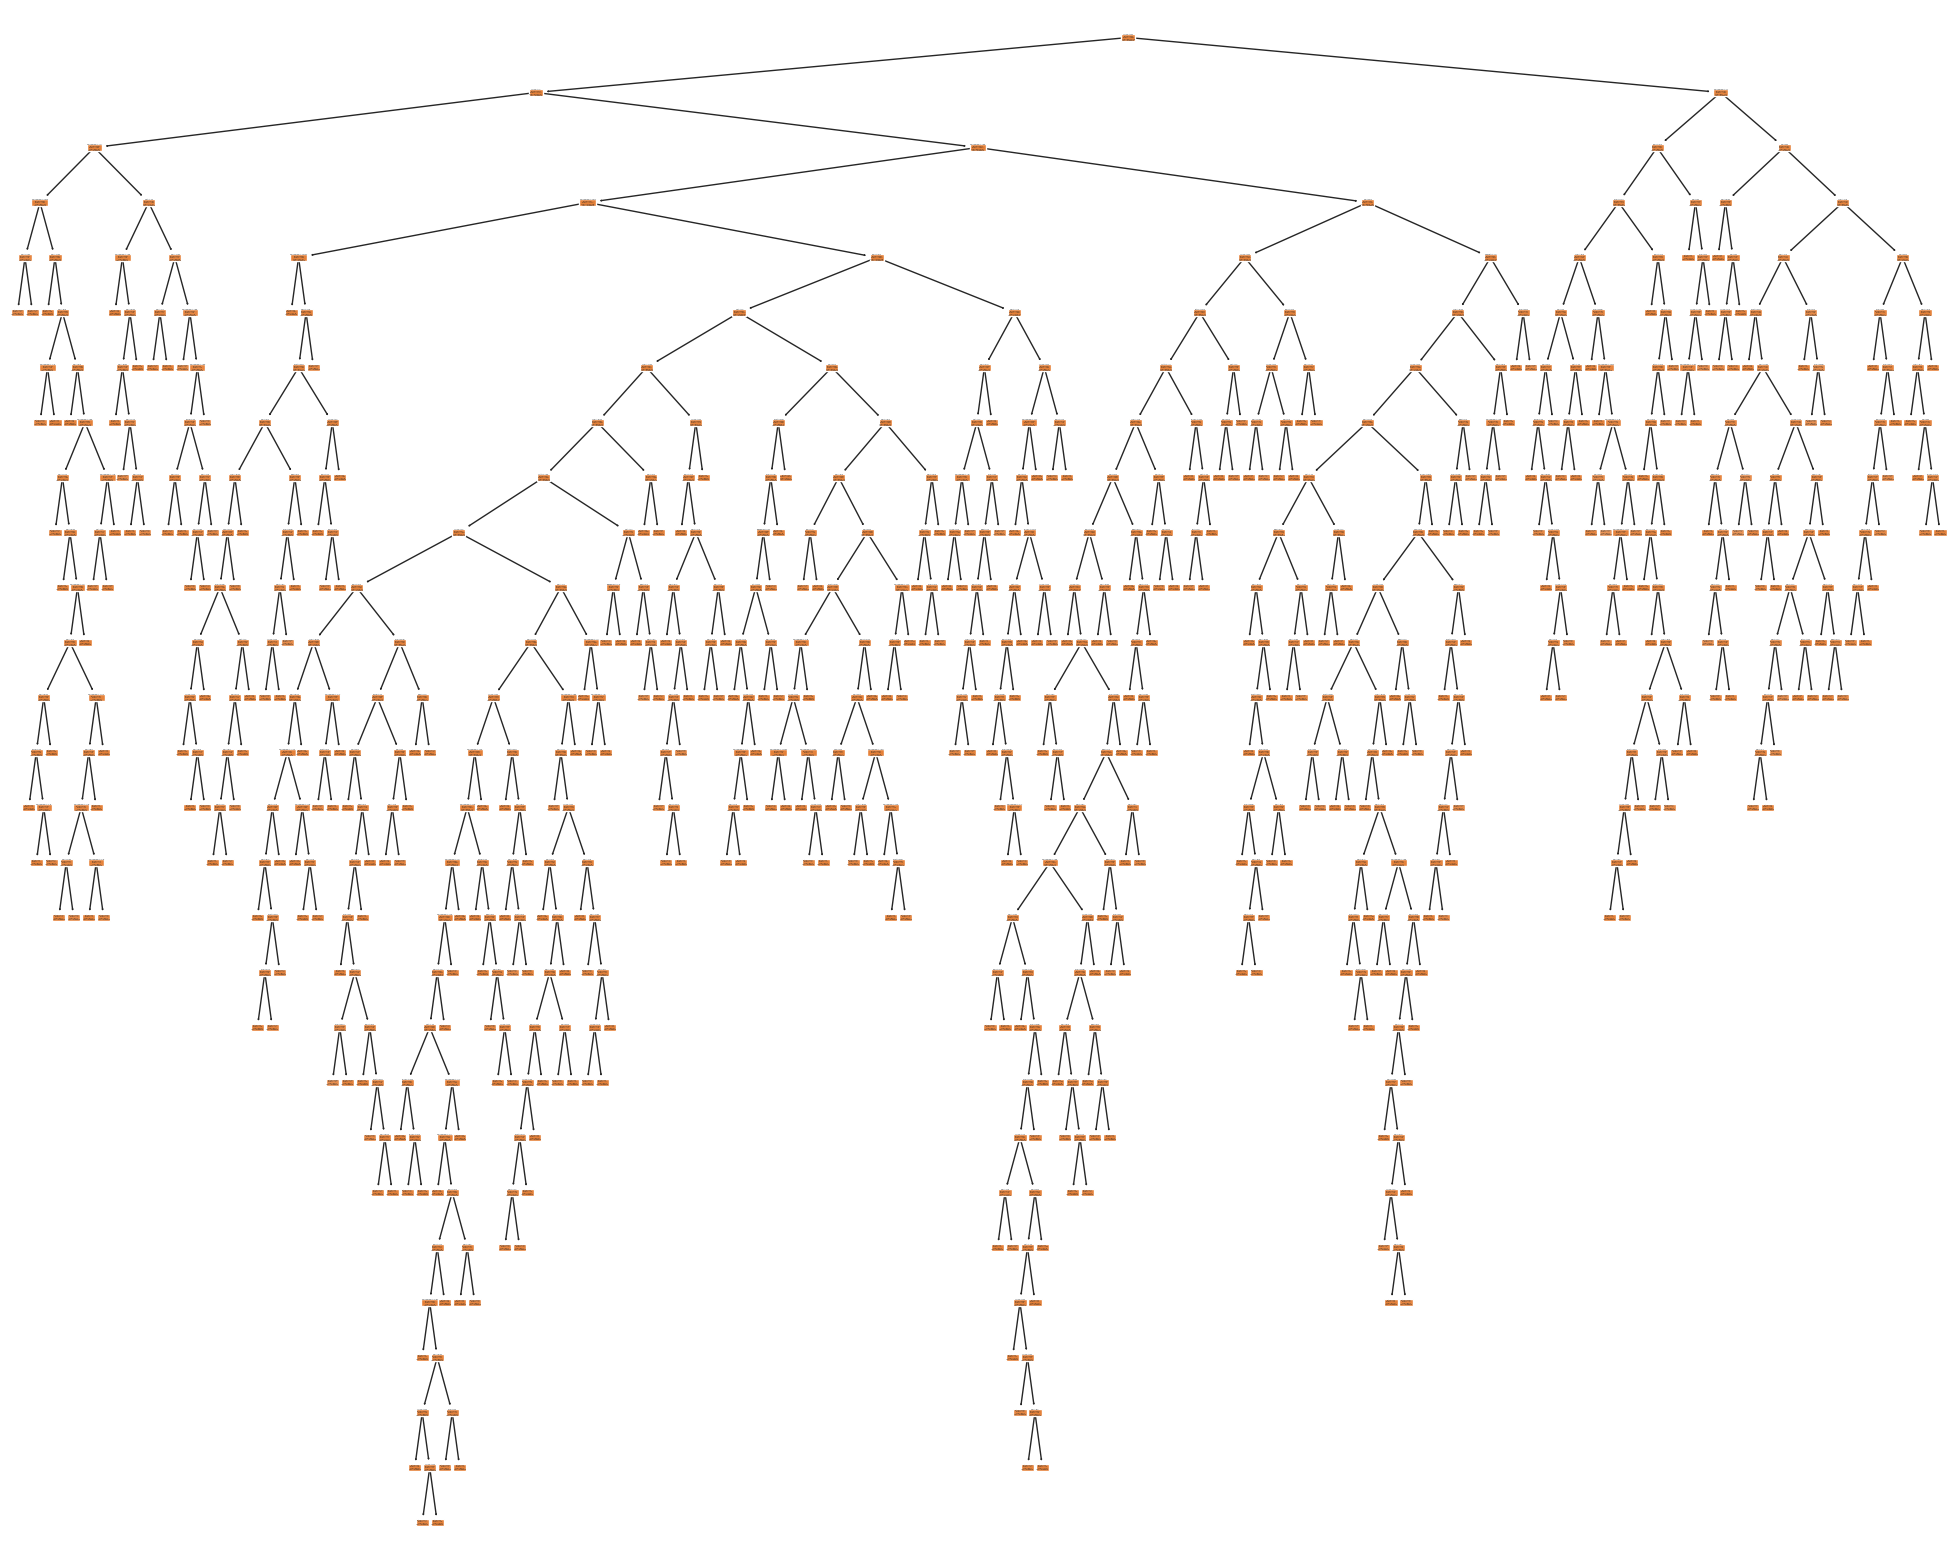

In [12]:
DecisionTree(train_data_x,train_data_y,test_data_x,test_data_y)

In [34]:
DecisionTree(train_data_new_x,train_data_new_y,test_data_new_x,test_data_new_y)

Accuracy is 0.8880937764299509
F1 score is 0.3772378704124573
Confusion Matrix:
[[324204  18365]
 [ 24108  12864]]


Accuracy is 0.9556
F1 score is 0.6407766990291264
Confusion Matrix:
[[9160   99]
 [ 345  396]]


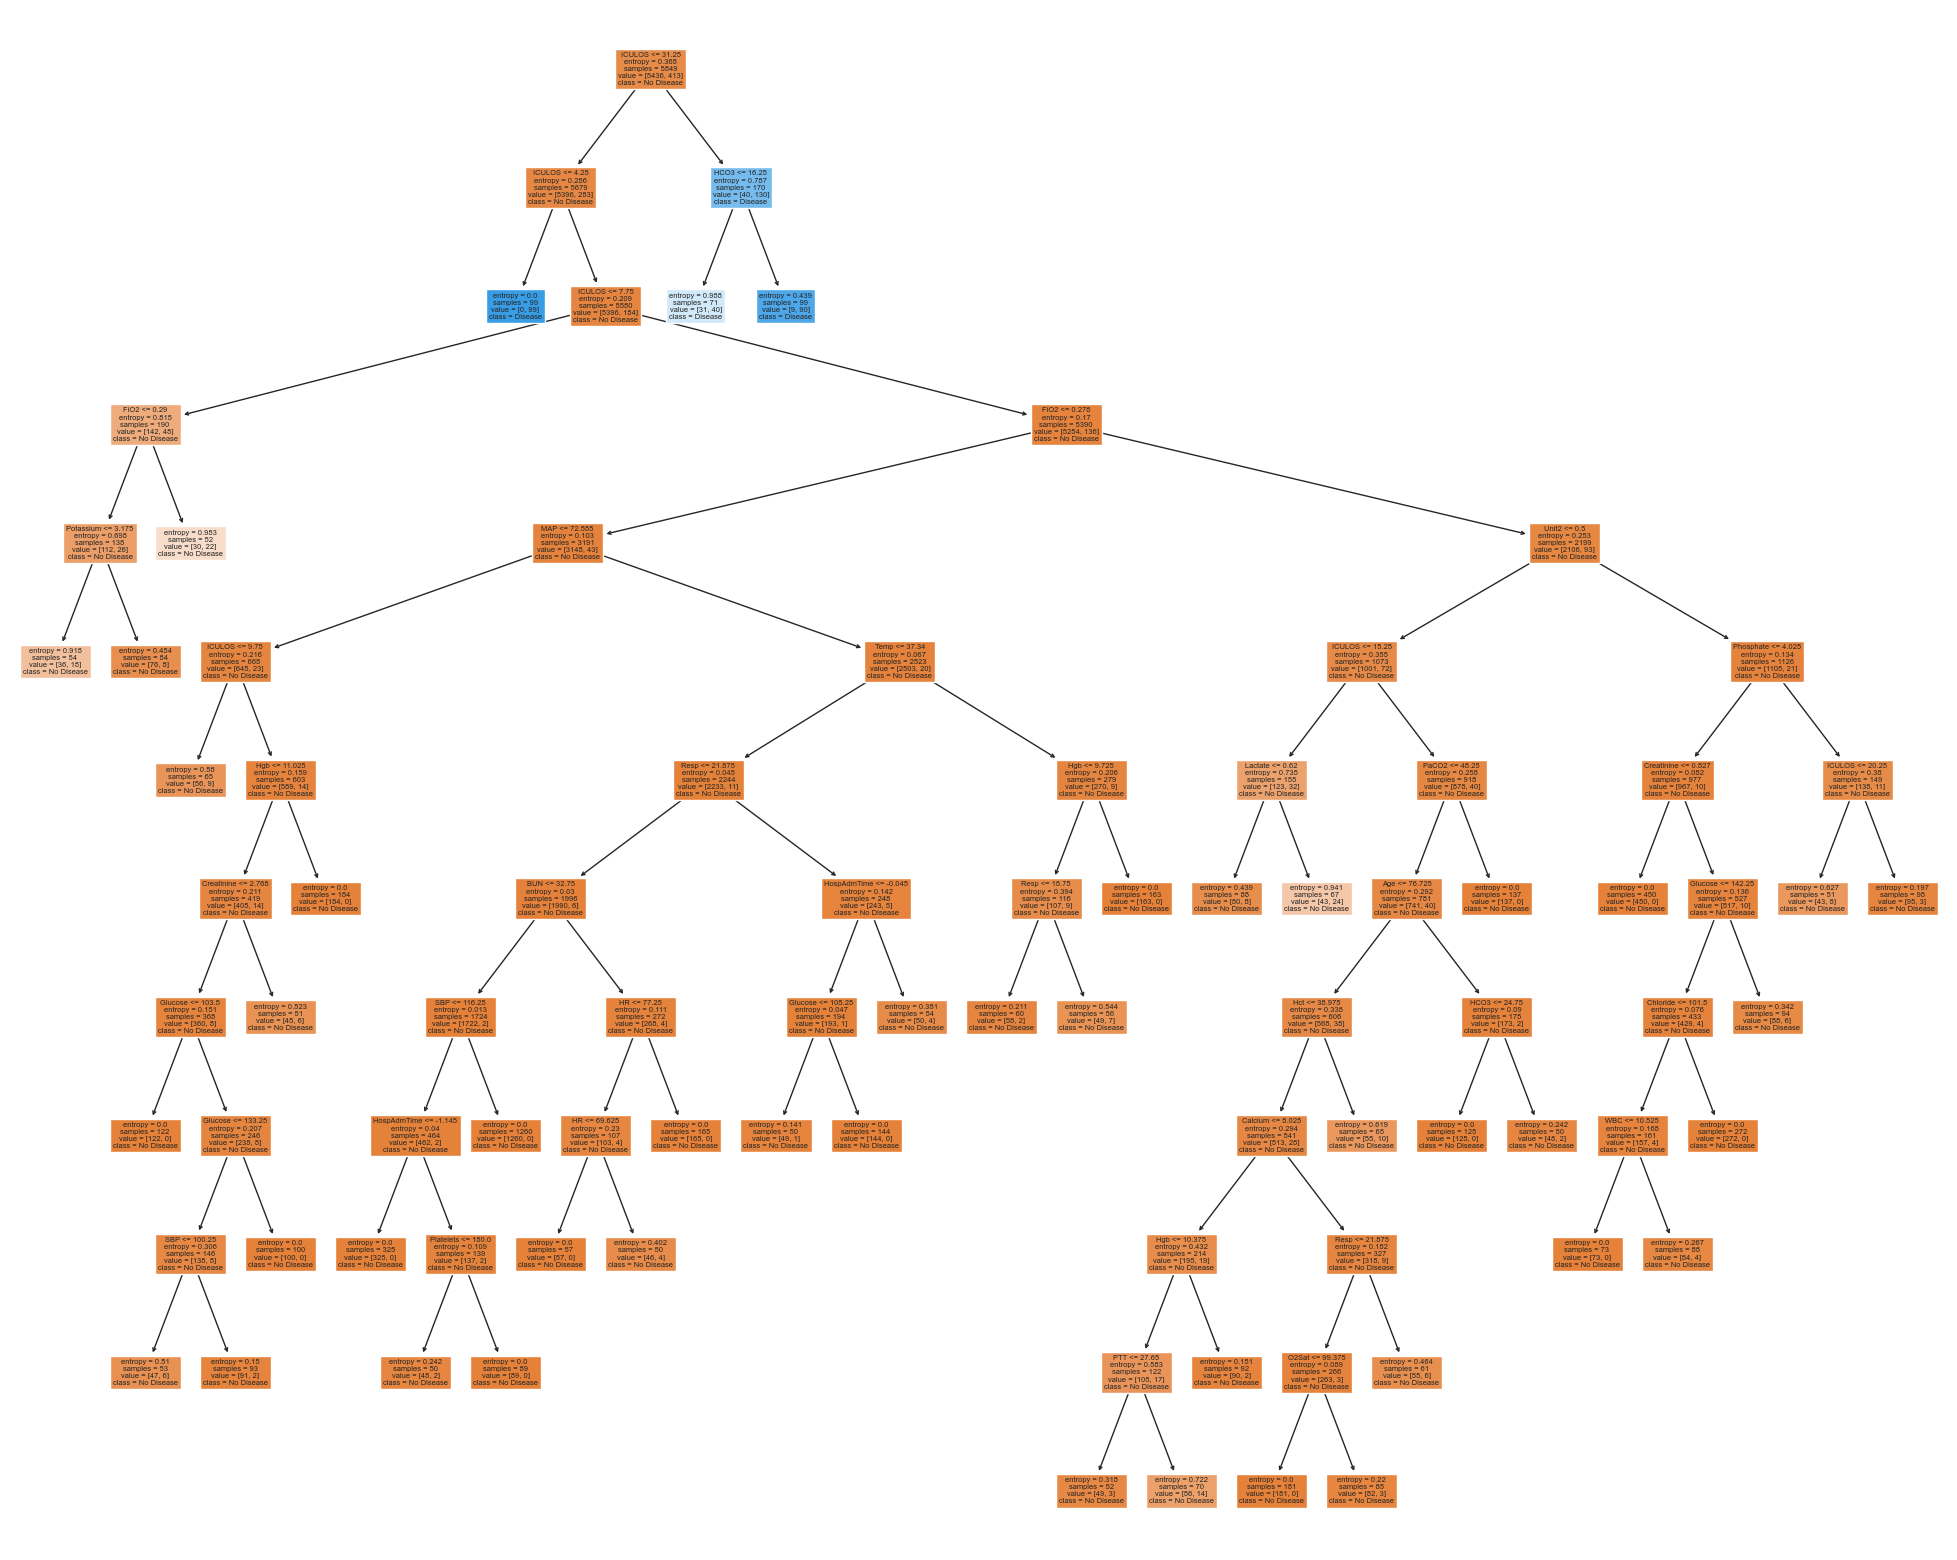

In [31]:
DecisionTree(train_data_agg_x,train_data_agg_y,test_data_agg_x,test_data_agg_y)

Accuracy is 0.9556
F1 score is 0.6407766990291264
Confusion Matrix:
[[9160   99]
 [ 345  396]]


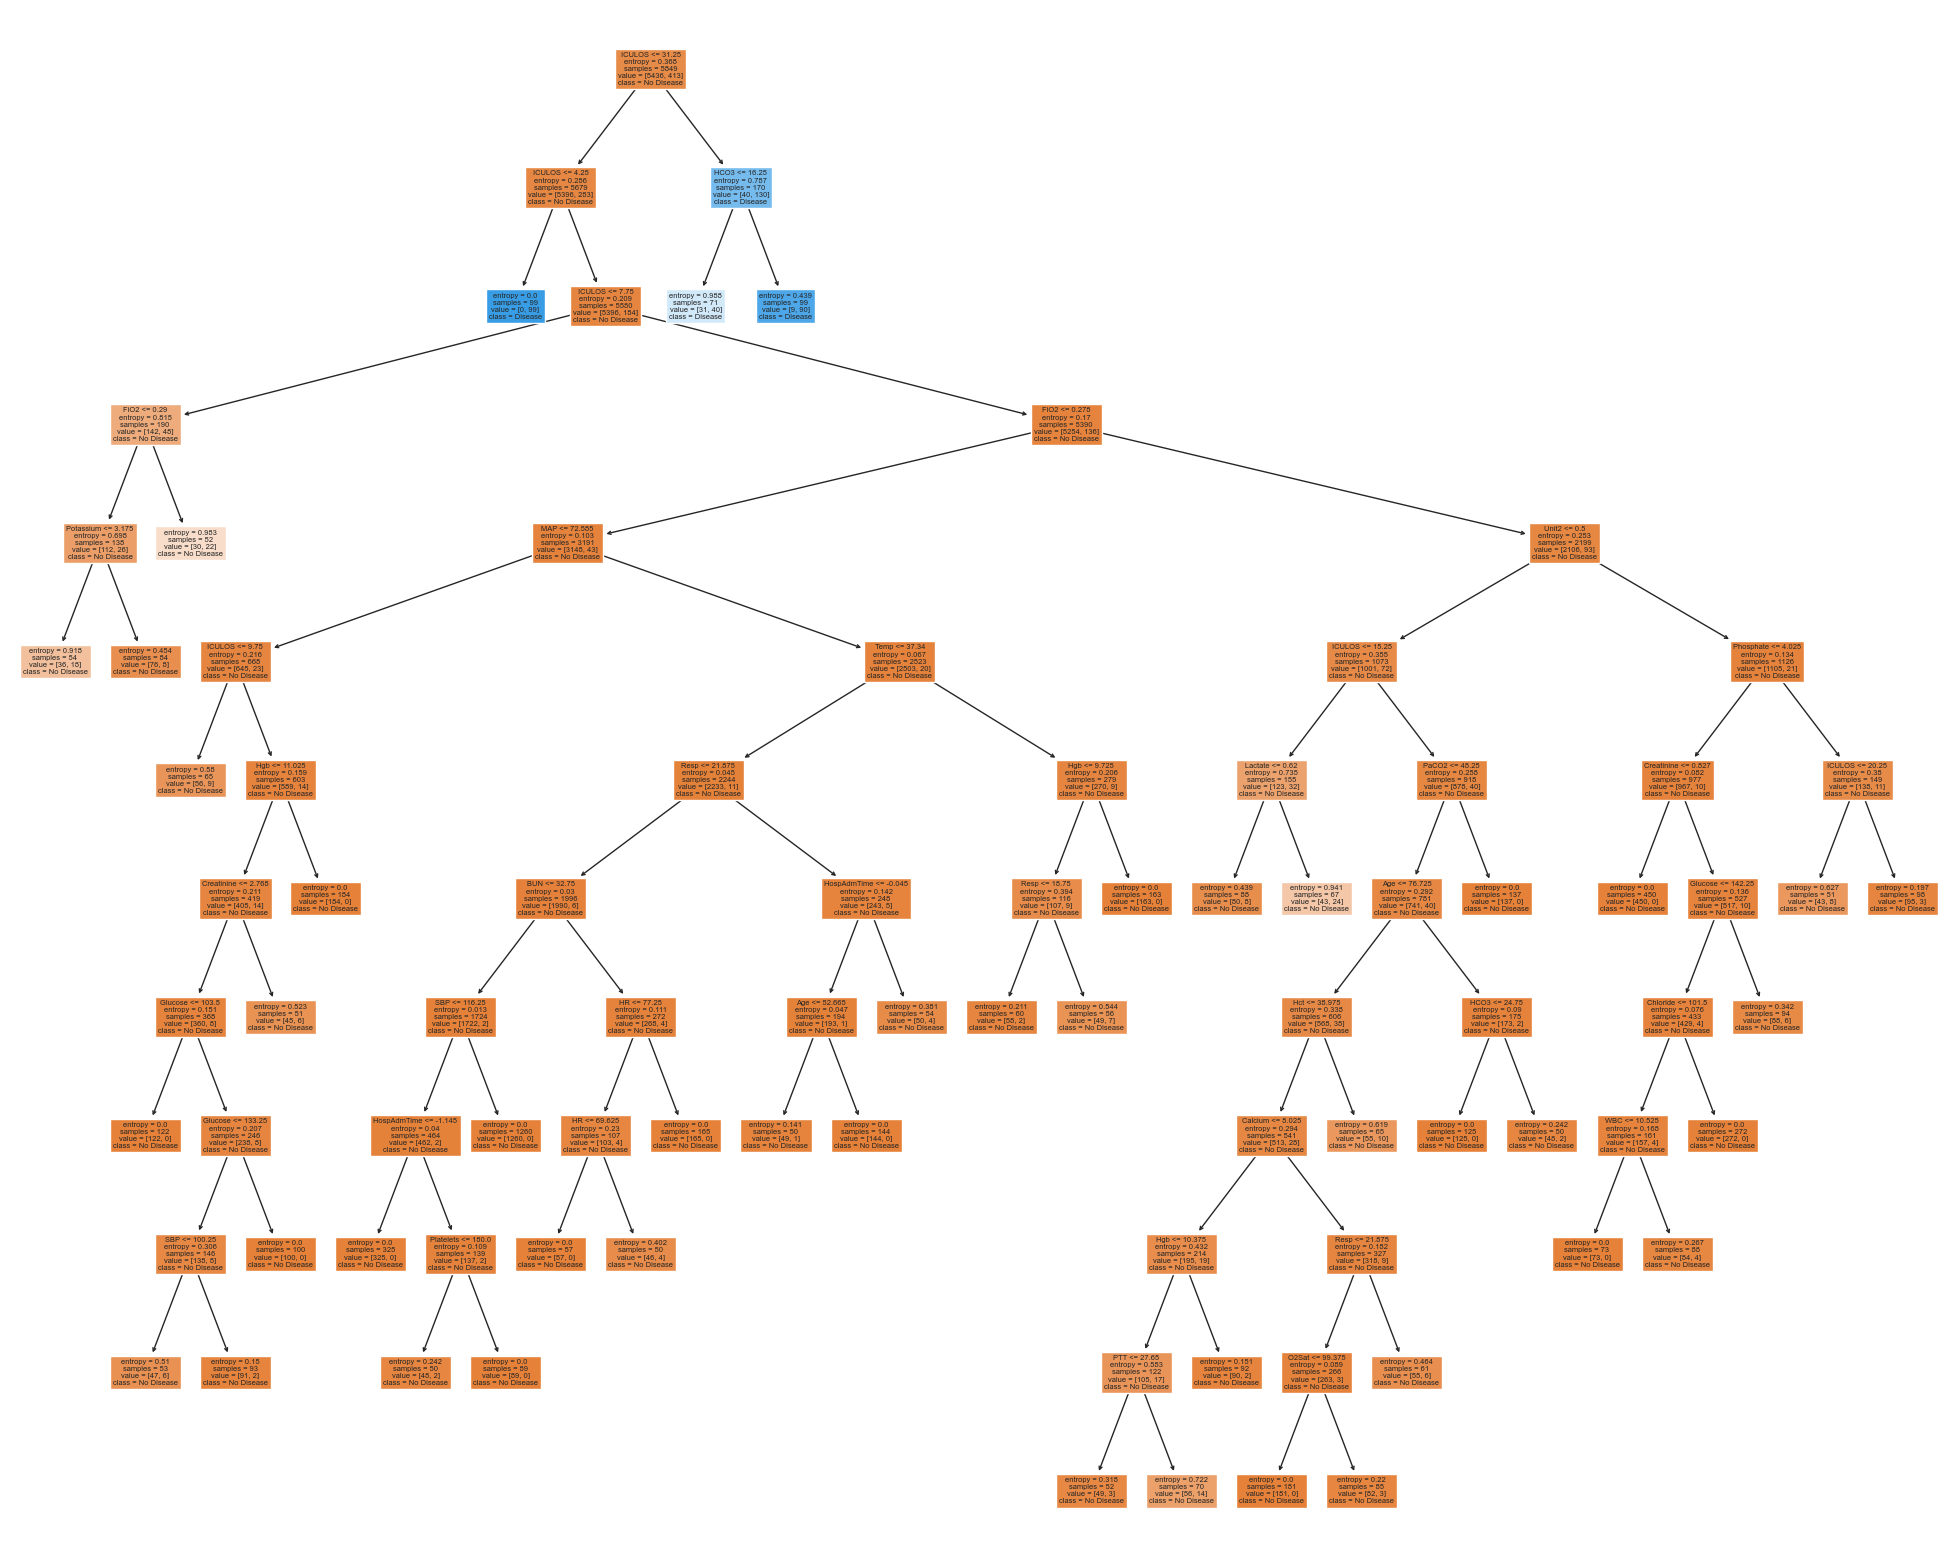

In [25]:
DecisionTree(train_data_new_agg_x,train_data_new_agg_y,test_data_new_agg_x,test_data_new_agg_y)